**LLaMA**

In [1]:
TRAIN_PATH = '21.jsonl'
MODEL_PATH = 'llama' #folder with model.py and tokenizer.py
TRAINED_SPM_PATH = 'tokenizer.model' #pretrained tokenizer

In [2]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import matplotlib.pyplot as plt

**Init**

In [3]:
MAX_SEQ_LEN = 256 #hard cap for memory constrained-systems
INGESTED_SAMPLE_CNT = 128
MAX_BSZ = 8

In [4]:
import sys
sys.path.append(MODEL_PATH)

# Copyright (c) Meta Platforms, Inc. and affiliates.
# This software may be used and distributed according to the terms of the GNU General Public License version 3.
from model_train import ModelArgs, Transformer #no cuda, no inference mode, no output projection (all sequences),\
                                               #no init_method=lambda x: x (fairscale default),\
                                               #remove self.cache; not for training,
from tokenizer_zeropad import Tokenizer #override default padding to 0 to shut tok_embed up about indexing

Configure environment for CPU

In [5]:
import torch
import torch.distributed as dist
import fairscale.nn.model_parallel.initialize as fs_init

%env RANK=0
%env WORLD_SIZE=1
%env MASTER_ADDR=localhost
%env MASTER_PORT=0

torch.distributed.init_process_group(backend='gloo')
fs_init.initialize_model_parallel(1) #1 worker

env: RANK=0
env: WORLD_SIZE=1
env: MASTER_ADDR=localhost
env: MASTER_PORT=0
> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


**Data**

In [6]:
def examine_data(data):
    '''debugging func'''
    print('First 50 chars: {}'.format(data[0]['text'][:50]))
    print('Input type: {}'.format(type(data)))
    print('Length: {}'.format(len(data)))
    print('First element type: {}'.format(type(data[0])))
    if type(data[0])==dict:
        print('Keys: {}'.format(data[0].keys()))
    return

def make_data_list(filepath:str, maxiter:int): #no much better way; maybe webtext for bonus point
    '''ingests JSON into list (with tripwire parameter to prevent computer from crashing)'''
    data = []
    with open(filepath, 'r') as f:
        for i, line in enumerate(f):
            if i >= maxiter:
                break
            data.append(json.loads(line))
    return data

raw_data_list = make_data_list(TRAIN_PATH, INGESTED_SAMPLE_CNT)
examine_data(raw_data_list)

First 50 chars: ---
abstract: 'We categorify the notion of an infi
Input type: <class 'list'>
Length: 128
First element type: <class 'dict'>
Keys: dict_keys(['text', 'meta'])


**Ablation study**

Setup

In [7]:
tokenizer = Tokenizer(TRAINED_SPM_PATH)
model_args = ModelArgs(
    dim=512,
    n_layers=8,
    n_heads=8,
    vocab_size=tokenizer.n_words,
    multiple_of=256,
    norm_eps=1e-5,
    max_batch_size=MAX_BSZ,
    max_seq_len=MAX_SEQ_LEN,
)

Distribution of Sequence Lengths

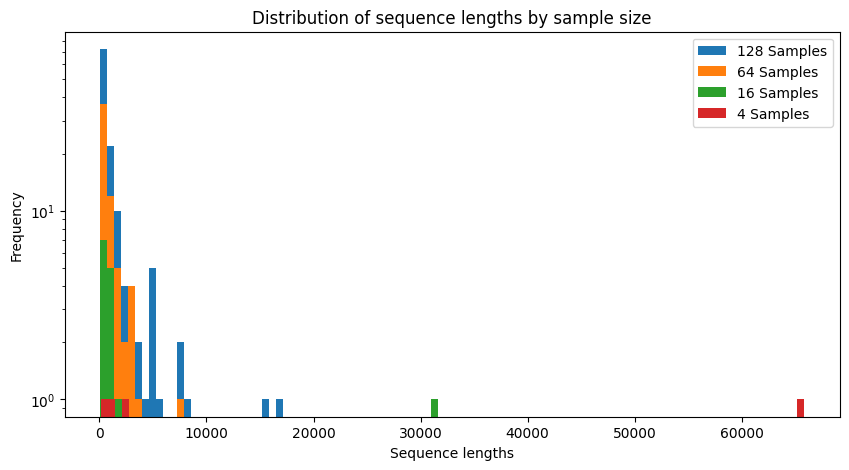

In [8]:
def plot_seqlen_dist(data, tokenizer, num_samples_list):
    '''plots distribution of seq_lens'''
    plt.figure(figsize=(10, 5))

    for num_samples in num_samples_list:
        seqlens = []

        for item in data[:num_samples]:
            text = item['text']
            encoded_text = tokenizer.encode(text, bos=False, eos=False)
            seqlens.append(len(encoded_text))

        plt.hist(seqlens, bins=100, label='{} Samples'.format(num_samples), log=True)
        
    plt.xlabel('Sequence lengths')
    plt.ylabel('Frequency')
    plt.title('Distribution of sequence lengths by sample size')
    #plt.xlim(0,10000)
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_seqlen_dist(raw_data_list, tokenizer, [128, 64, 16, 4])

Sequence Length Handling

In [9]:
class AblationDataset(Dataset):
    def __init__(self, data, tokenizer, underflow_policy:str, overflow_policy:str, max_len:int, overflow_tol=None):
        self.tokenizer = tokenizer
        self.underflow_policy = underflow_policy
        self.overflow_policy = overflow_policy
        self.overflow = []
        self.encoded_data = [] 
        self.max_len = max_len 
        self.overflow_tol = overflow_tol

        #see docstrings of class functions
        if self.overflow_policy=='discard': #lazy
            self.discard_overflow(data)
        elif self.overflow_policy=='impute': #naive
            self.impute_overflow(data)
        elif (self.overflow_policy=='informed' and self.overflow_tol!=None): #lazy or naive
            self.informed_overflow(data)
        else:
            exit('invalid overflow policy')

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        encoded_text = self.encoded_data[idx]

        if self.underflow_policy=='padding':
            input_ids, target_ids = self.pad_sequence(encoded_text)
            return {
                'input_ids': torch.tensor(input_ids, dtype=torch.long),
                'target_ids': torch.tensor(target_ids, dtype=torch.long)
            }
        else: #default underflow handling: throw away sequences shorter than max_len
            return {
                'input_ids': torch.tensor([self.tokenizer.bos_id] + encoded_text, dtype=torch.long),
                'target_ids': torch.tensor(encoded_text + [self.tokenizer.eos_id], dtype=torch.long)
            }

    def discard_overflow(self, data):
        '''throw away sequence fragments exceeding the cap'''
        for item in data:
            text = item['text']
            encoded_text = self.tokenizer.encode(text, bos=False, eos=False)
            if len(encoded_text) > self.max_len: 
                self.encoded_data.append(encoded_text[:self.max_len])
            else:
                self.encoded_data.append(encoded_text)

    def impute_overflow(self, data):
        '''iteratively impute leftover fragments as new sequences'''
        for item in data:
            text = item['text']
            encoded_text = self.tokenizer.encode(text, bos=False, eos=False)
            self.overflow += encoded_text

            while len(self.overflow) >= self.max_len: #handles fragments which themselves are too long
                self.encoded_data.append(self.overflow[:self.max_len])
                self.overflow = self.overflow[self.max_len:]

        if len(self.overflow) == self.max_len:
            self.encoded_data.append(self.overflow)

    def pad_sequence(self, encoded_text):
        '''fill to end with padding token'''
        padding = [self.tokenizer.pad_id] * (self.max_len - len(encoded_text))
        input_ids = [self.tokenizer.bos_id] + encoded_text + padding
        target_ids = encoded_text + [self.tokenizer.eos_id] + padding
        return input_ids, target_ids

    def informed_overflow(self, data):
        '''determine whether to discard or impute leftovers based on length (overflow_tol)'''
        for item in data:
            text = item['text']
            encoded_text = self.tokenizer.encode(text, bos=False, eos=False)
            self.overflow += encoded_text

            while len(self.overflow) >= self.max_len: #handles fragments which themselves are too long
                if len(self.overflow) - self.max_len < self.overflow_tol:
                    self.encoded_data.append(self.overflow[:self.max_len])

                self.overflow = self.overflow[self.max_len:]

        if len(self.overflow) == self.max_len:
            self.encoded_data.append(self.overflow)

In [10]:
def train(dataloader, record=False, early_stop=False):
    '''computationally inefficient; for small-scale experimentation only'''
    model = Transformer(model_args)
    optimizer = torch.optim.AdamW(model.parameters()) 
    if record:
        batch_idx = 0
        losses=[]

    model.train()
    total_loss = 0
    for batch in dataloader:
        inputs = batch['input_ids'] #bsz x seq_len 
        targets = batch['target_ids'] #bsz x seq_len

        outputs = model(inputs, start_pos=0) #bsz x sel_len x vocab_size
        flat_outputs = outputs.view(-1, outputs.size(-1)) #(bsz*seq_len) x vocab_size
        flat_targets = targets.view(-1) #(bsz*seq_len)
        loss = loss_func(flat_outputs, flat_targets) #flattening confirmed by TA

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

        if record:
            batch_idx += 1
            losses.append(loss.item())
        
        if early_stop:
            if batch_idx==early_stop:
                break

    avg_train_loss = total_loss / len(dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    
    if record:
        return losses, avg_train_loss

In [11]:
def find_min_len(data):
    '''locate smallest sequence length in input'''
    min_len = float('inf')
    for item in data:
        text = item['text']
        encoded_text = tokenizer.encode(text, bos=False, eos=False)
        #print(len(encoded_text),end=',')
        min_len = min(min_len, len(encoded_text))
        
    return min_len

smallest_seq_len = find_min_len(raw_data_list)
print('\nminimum: {}'.format(str(smallest_seq_len)))


minimum: 39


In [12]:
MIN_SEQ_LEN = smallest_seq_len

In [13]:
def plot_losses_min(losses1, avg_loss1, losses2, avg_loss2, title:str):
    '''plot 2 min losses annotated with their average; loss wrt. batch'''
    min_batches = min(len(losses1), len(losses2)) #smallest minimum length
    plt.figure(figsize=(10, 6))

    #marginal loss
    plt.plot(losses1[:min_batches], label='Discard Policy - Marginal Loss', color='blue')
    plt.plot(losses2[:min_batches], label='Impute Policy - Marginal Loss', color='orange')
    
    #average loss annotation
    plt.annotate(f'Avg Loss (Discard): {avg_loss1:.2f}', xy=(0.7, 0.85), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="blue", lw=2))
    plt.annotate(f'Avg Loss (Impute): {avg_loss2:.2f}', xy=(0.7, 0.8), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", lw=2))

    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training loss over first {} batches for seq_len={}'.format(min_batches, title))
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def plot_losses(losses, color, title):
    '''loss wrt. batch'''
    plt.figure(figsize=(10,6))
    plt.plot(losses, color=color)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Batch for '+title)
    plt.show()

**Execution**

Naive Underflow Handling

Average training loss: 8.89
Average training loss: 0.14


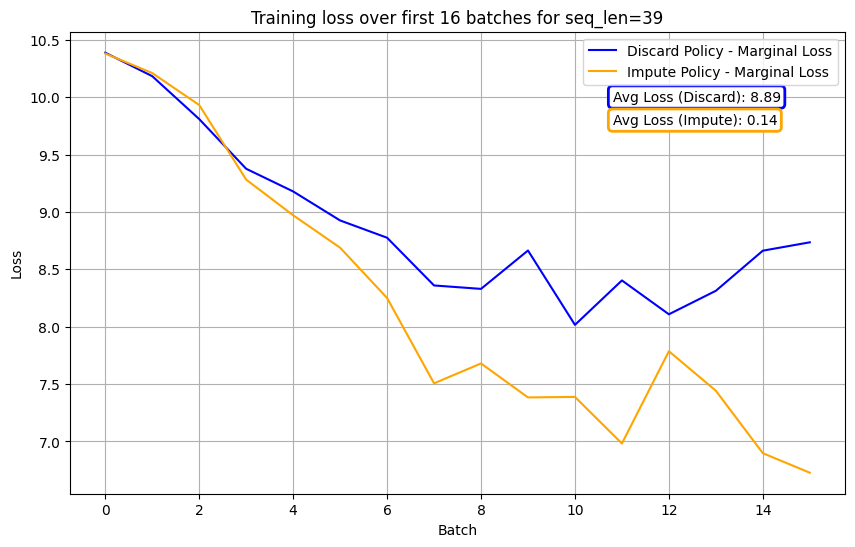

In [15]:
loss_func = torch.nn.CrossEntropyLoss() #no padding to ignore here
naive_discard_dataset = AblationDataset(
    data = raw_data_list,
    tokenizer = tokenizer,
    underflow_policy = None,
    overflow_policy = 'discard',
    max_len = MIN_SEQ_LEN-1
    )
naive_discard_dataloader = DataLoader(naive_discard_dataset, batch_size=model_args.max_batch_size) #no shuffling
results_discard = train(naive_discard_dataloader, record=True)

naive_impute_dataset = AblationDataset(
    data = raw_data_list,
    tokenizer = tokenizer,
    underflow_policy = None,
    overflow_policy = 'impute',
    max_len = MIN_SEQ_LEN-1
    )
naive_impute_dataloader = DataLoader(naive_impute_dataset, batch_size=model_args.max_batch_size) #no shuffling
results_impute = train(naive_impute_dataloader, record=True, early_stop=16)

plot_losses_min(results_discard[0], results_discard[1], results_impute[0], results_impute[1], title=MIN_SEQ_LEN)

Naive underflow policy

Average training loss: 8.90
Average training loss: 0.07


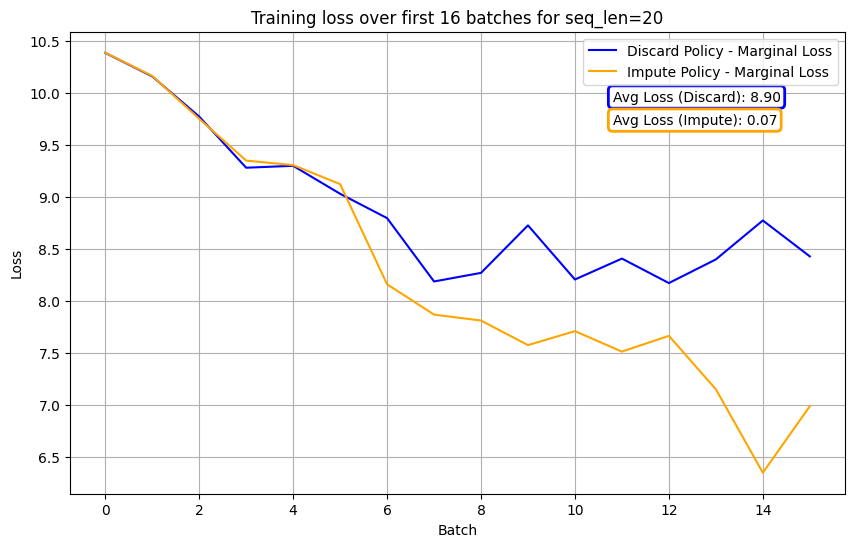

In [16]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id) #ignore padding tokens
MAX_LEN = 20
pad_discard_dataset = AblationDataset (
    data = raw_data_list,
    tokenizer = tokenizer,
    underflow_policy = 'padding',
    overflow_policy = 'discard',
    max_len = MAX_LEN-1
    )
pad_discard_dataloader = DataLoader(pad_discard_dataset, batch_size=model_args.max_batch_size) #no shuffling
pad_discard_len = len(pad_discard_dataloader)

pad_impute_dataset = AblationDataset(
    data = raw_data_list,
    tokenizer = tokenizer,
    underflow_policy = 'padding',
    overflow_policy = 'impute',
    max_len = MAX_LEN-1
    )
pad_impute_dataloader = DataLoader(pad_impute_dataset, batch_size=model_args.max_batch_size) #no shuffling
pad_impute_len = len(pad_impute_dataloader)
gcd = min(pad_discard_len, pad_impute_len)

results_discard = train(pad_discard_dataloader, record=True, early_stop=gcd)
results_impute = train(pad_impute_dataloader, record=True, early_stop=gcd)
plot_losses_min(results_discard[0], results_discard[1], results_impute[0], results_impute[1], title=MAX_LEN)

Informed padding

In [17]:
import numpy as np
def plot_losses_extended(losses_avg_list, legend_labels):
    num_cases = len(losses_avg_list)
    max_batches = max(len(losses) for losses, _ in losses_avg_list)
    if max_batches > 16:
        max_batches = 16
    extended_losses_avg_list = []
    for losses, avg_loss in losses_avg_list:
        losses = losses[:max_batches]
        x = np.arange(len(losses))
        extended_losses_avg_list.append((x, losses, avg_loss))
    plt.figure(figsize=(10, 6))
    for i, (x, losses, _) in enumerate(extended_losses_avg_list):
        plt.plot(x, losses, label=legend_labels[i])
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title(f'Training loss over {max_batches} batches {legend_labels}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id) #ignore padding tokens
MAX_LEN = 100
overflow_tols = [50,100,150,200]
result_tuples = []
for overflow_tol in overflow_tols:
    informed_dataset = AblationDataset (
        data = raw_data_list,
        tokenizer = tokenizer,
        underflow_policy = 'padding',
        overflow_policy = 'informed',
        max_len = MAX_LEN-1,
        overflow_tol=overflow_tol
        )
    informed_dataloader = DataLoader(informed_dataset, batch_size=model_args.max_batch_size) #no shuffling
    results_informed = train(informed_dataloader, record=True, early_stop=16)
    result_tuples.append(results_informed)

plot_losses_extended(result_tuples, overflow_tols)

Average training loss: 9.21
Average training loss: 8.63
Average training loss: 5.57


KeyboardInterrupt: 